In [1]:
import os
import glob
import json
import shutil

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/raj-learn/lth/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
from matplotlib import font_manager
from matplotlib import rcParams
fpath = '/raj-learn/envs/contextual_repr_analysis/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf'
prop = font_manager.FontProperties(fname=fpath)
rcParams['font.family'] = prop.get_name()
rcParams['mathtext.fontset'] = 'cm'
rcParams['axes.unicode_minus'] = False

### Analysis 1: compare simple linear probe performance at increasing sparsity
For each task, make a heatmap plotting performance for each (model, layer) combination.

In [43]:
probing_result_dir = '/raj-learn/checkpoints/probing_models'
tasks = [ # token level
         'ptb_pos_tagging', 
         'ccg_supertagging', 
         'syntactic_constituency_parent',
         'syntactic_constituency_gparent',
         'syntactic_constituency_ggparent',
         'semantic_tagging',
         'adposition_supersense_tagging_function',
         'adposition_supersense_tagging_role',
         'event_factuality',
          # segmentation
         'conll2000_chunking',
         'conll2003_ner',
         'grammatical_error_correction',
         'conjunct_identification',
          # pairwise relations
         'syntactic_dependency_arc_prediction',
         'syntactic_dependency_arc_classification',
         'semantic_dep_prediction',
         'semantic_dep_classification',
         'coref_resolution'
        ]
models = ['LTH' + str(i) for i in range(9)]
layers = list(range(6))

In [6]:
# %%time
# for rep in range(1, 6):
# #     for task in ['adposition_supersense_tagging_function', 'adposition_supersense_tagging_role', 'coref_resolution']:
#     for task in ['coref_resolution']:
#         dirs = glob.glob(f'{probing_result_dir}/LTH*/{task}/replicate{rep}_layer*/')
#         print(len(dirs))
#         for dirpath in dirs:
#             shutil.rmtree(dirpath)

In [179]:
%%time
# val_perfs = {'all': [], 'accuracy' : [], 'accuracy3' : [], 'pearson_r' : []}
# test_perfs = {'all': [], 'accuracy' : [], 'accuracy3' : [], 'pearson_r' : []}
metric_dict = {task : {model : [] for model in models} for task in tasks}

token = ['ptb_pos_tagging', 
         'ccg_supertagging', 
         'syntactic_constituency_parent',
         'syntactic_constituency_gparent',
         'syntactic_constituency_ggparent',
         'semantic_tagging',
         'adposition_supersense_tagging_function',
         'adposition_supersense_tagging_role',
         'event_factuality']
chunking = ['conll2000_chunking',
         'conll2003_ner',
         'grammatical_error_correction',
         'conjunct_identification',]
pairwise = ['syntactic_dependency_arc_prediction',
         'syntactic_dependency_arc_classification',
         'semantic_dep_prediction',
         'semantic_dep_classification',
         'coref_resolution']

for task in tasks:
    for model in models:
        for layer in layers:
            path = f'{probing_result_dir}/{model}/{task}/*_layer{layer}/metrics.json'
            files = glob.glob(path)
            scores = []
            if len(files) == 0:
                print(task, model, layer)
                metric_dict[task][model].append(np.nan)
                continue
            for file in files:
                with open(file) as f:
                    metrics = json.load(f)
                    if task == 'event_factuality':
#                         val = metrics['validation_pearson_r']
#                         val_perfs['all'].append(val)
#                         val_perfs['pearson_r'].append(val)
                        test = metrics['test_pearson_r']
#                         test_perfs['all'].append(test)
#                         test_perfs['pearson_r'].append(test)
                        scores.append(test)
                    elif task in chunking:
                        if task == 'grammatical_error_correction':
                            scores.append(metrics['test_label_i_f1'])
                        else:
                            scores.append(metrics['test_f1-measure-overall'])
                    else:
#                         val, val3 = metrics['validation_accuracy'], metrics['validation_accuracy3']
#                         val_perfs['all'].extend([val, val3])
#                         val_perfs['accuracy'].append(val)
#                         val_perfs['accuracy3'].append(val3)
                        test, test3 = metrics['test_accuracy'], metrics['test_accuracy3']
#                         test_perfs['all'].extend([test, test3])
#                         test_perfs['accuracy'].append(test)
#                         test_perfs['accuracy3'].append(test3)
                        scores.append(test)
            avg_score = np.nanmean(scores)
            metric_dict[task][model].append(avg_score)
        metric_dict[task][model] = np.array(metric_dict[task][model])

syntactic_constituency_parent LTH8 0
syntactic_constituency_parent LTH8 1
syntactic_constituency_parent LTH8 2
syntactic_constituency_parent LTH8 3
syntactic_constituency_parent LTH8 4
syntactic_constituency_parent LTH8 5
syntactic_constituency_gparent LTH8 0
syntactic_constituency_gparent LTH8 1
syntactic_constituency_gparent LTH8 2
syntactic_constituency_gparent LTH8 3
syntactic_constituency_gparent LTH8 4
syntactic_constituency_gparent LTH8 5
syntactic_constituency_ggparent LTH8 0
syntactic_constituency_ggparent LTH8 1
syntactic_constituency_ggparent LTH8 2
syntactic_constituency_ggparent LTH8 3
syntactic_constituency_ggparent LTH8 4
syntactic_constituency_ggparent LTH8 5
semantic_tagging LTH8 2
semantic_tagging LTH8 3
semantic_tagging LTH8 4
semantic_tagging LTH8 5
event_factuality LTH8 0
event_factuality LTH8 1
event_factuality LTH8 2
event_factuality LTH8 3
event_factuality LTH8 4
event_factuality LTH8 5
syntactic_dependency_arc_prediction LTH3 5
syntactic_dependency_arc_predicti

In [167]:
from scipy.stats import pearsonr, spearmanr

print(spearmanr(val_perfs['all'], test_perfs['all']))
print(spearmanr(val_perfs['accuracy'], test_perfs['accuracy']))
print(spearmanr(val_perfs['accuracy3'], test_perfs['accuracy3']))
print(spearmanr(test_perfs['accuracy'], test_perfs['accuracy3']))
print(spearmanr(val_perfs['accuracy'], val_perfs['accuracy3']))

SpearmanrResult(correlation=0.9960166782844083, pvalue=0.0)
SpearmanrResult(correlation=0.9853211369637873, pvalue=0.0)
SpearmanrResult(correlation=0.9963613329027436, pvalue=0.0)
SpearmanrResult(correlation=0.17242088407645537, pvalue=2.8687840935696943e-10)
SpearmanrResult(correlation=0.17798489758922767, pvalue=7.39345042532627e-11)


In [168]:
best_layer_perfs = {model : {} for model in models}

for task in metric_dict:
    for model in best_layer_perfs:
        best_layer_perfs[model][task] = max(metric_dict[task][model])

df_best_layer_perfs = pd.DataFrame(best_layer_perfs)
task_means = df_best_layer_perfs.mean(axis=1)
# df_norm_row = df_best_layer_perfs.sub(task_means, axis=0).div(df_best_layer_perfs.std(axis=1), axis=0)
df_norm_row = 100*df_best_layer_perfs.sub(task_means, axis=0).div(task_means, axis=0)
df_best_layer_perfs

,LTH0,LTH1,LTH2,LTH3,LTH4,LTH5,LTH6,LTH7,LTH8
ptb_pos_tagging,0.967826,0.968162,0.967408,0.968509,0.968478,0.968478,0.968122,0.968865,0.969386
ccg_supertagging,0.929804,0.929099,0.928622,0.928126,0.928355,0.930012,0.930238,0.929804,0.929501
syntactic_constituency_parent,0.951045,0.950613,0.951476,0.951524,0.951668,0.951572,0.950661,0.950110,NaN
syntactic_constituency_gparent,0.792701,0.792893,0.791838,0.789658,0.789634,0.789370,0.790017,0.790329,NaN
syntactic_constituency_ggparent,0.655947,0.653983,0.656403,0.651275,0.654150,0.652042,0.654965,0.647129,NaN
semantic_tagging,0.933116,0.934015,0.933992,0.933143,0.933086,0.933637,0.934566,0.934412,NaN
adposition_supersense_tagging_function,0.858065,0.858525,0.846544,0.839631,0.846544,0.841475,0.833180,0.826267,0.828111
adposition_supersense_tagging_role,0.739631,0.760369,0.755760,0.744240,0.737327,0.725806,0.716590,0.716590,0.720737
event_factuality,0.711749,0.713707,0.718988,0.721739,0.722469,0.722469,0.717368,0.716482,NaN
conll2000_chunking,0.913263,0.909733,0.912473,0.911829,0.910934,0.912977,0.914167,0.912209,0.911917


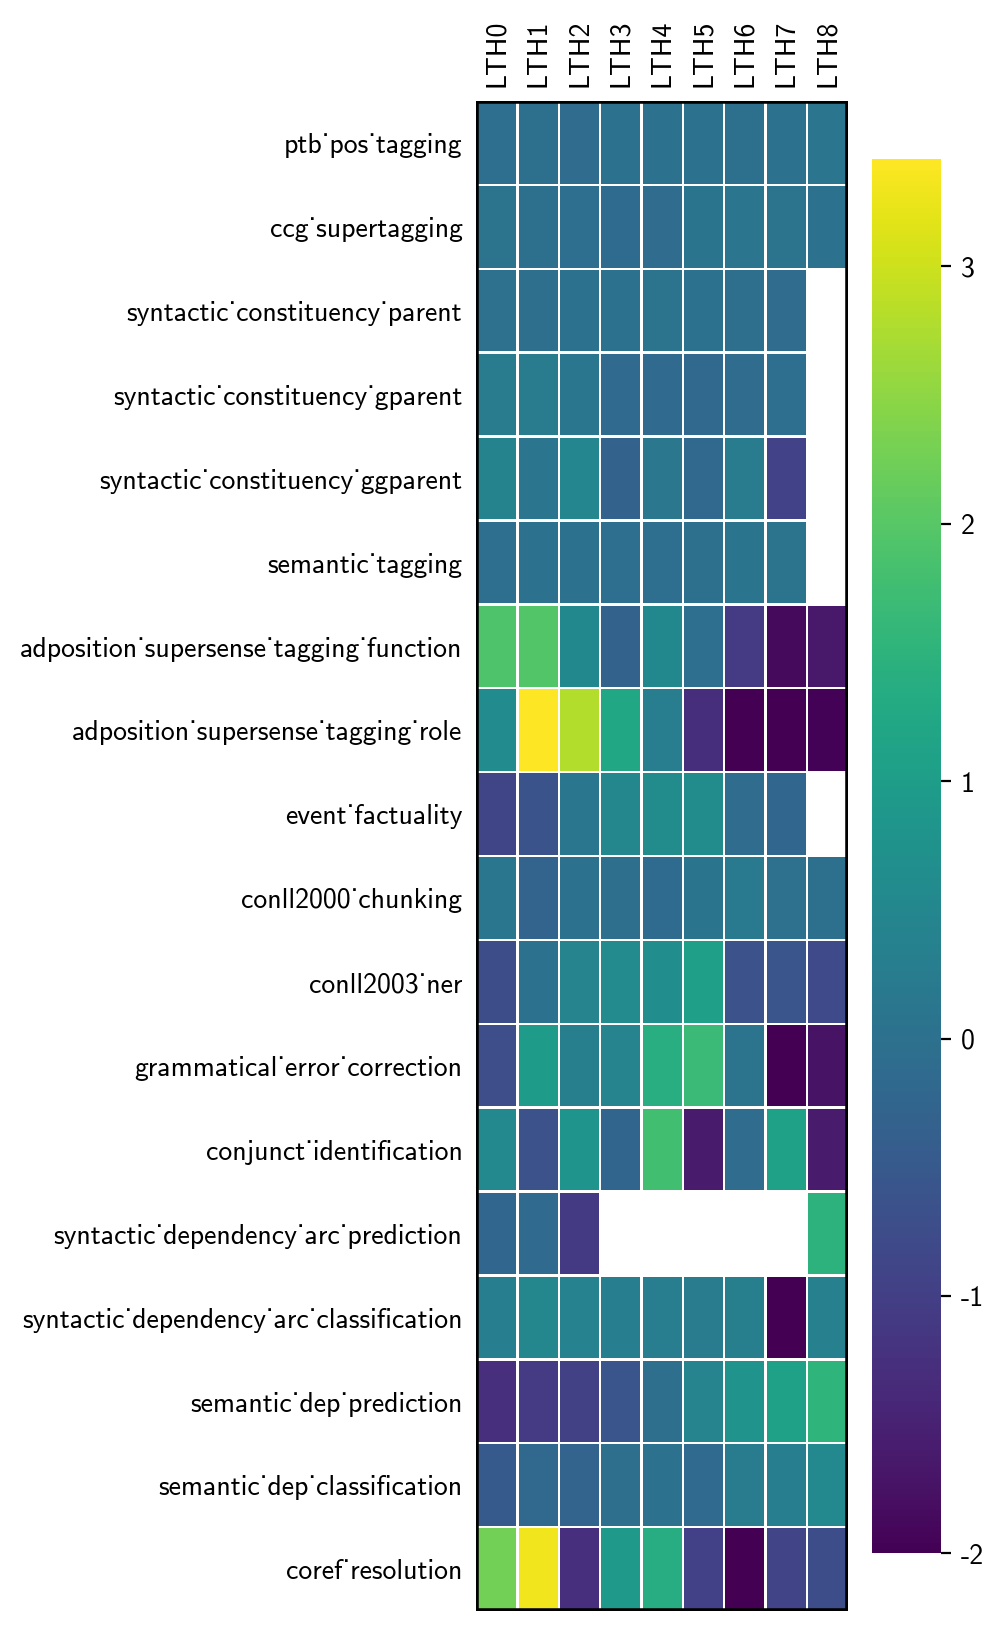

In [169]:
plt.figure(figsize=(3, 10), dpi=200)
df = df_norm_row
ax = sns.heatmap(data=df, cmap='viridis', lw=0.5, vmin=-2) # vmin=np.nanmin(df.values), vmax=np.nanmax(df.values))
ax.add_patch(Rectangle((0, 0), len(df.columns), len(df.index), fill=False, edgecolor='black', lw=2))
ax.xaxis.tick_top()
plt.xticks(rotation=90)
ax.tick_params(axis='both', which='both', length=0, pad=5)
# ax.set_title(' '.join(task.split('_')))
plt.show()

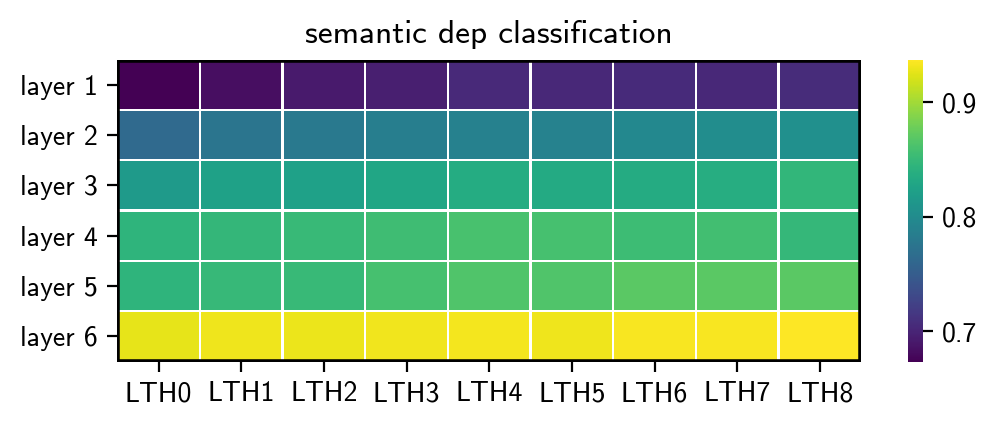

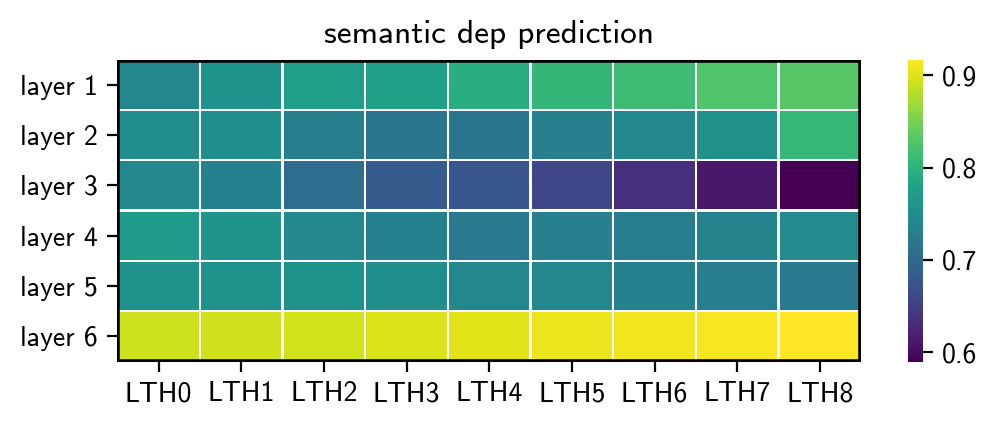

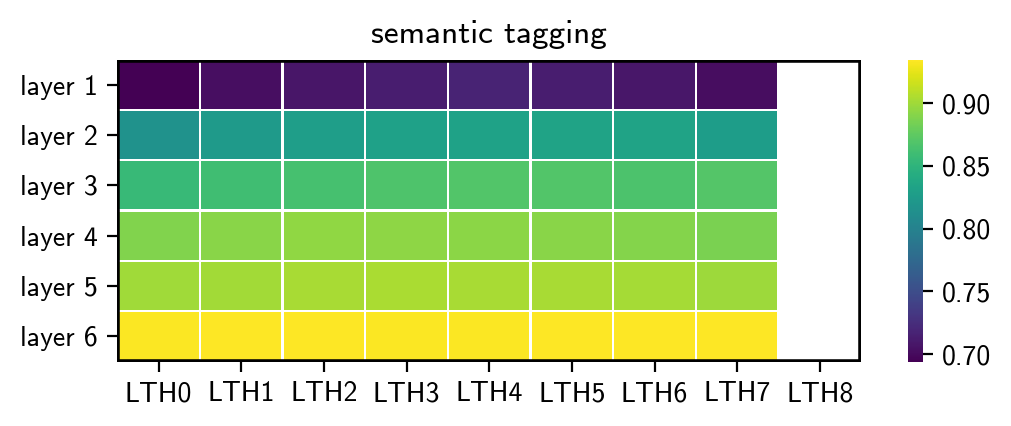

In [170]:
from matplotlib.patches import Rectangle

# for task in metric_dict:
for task in ['semantic_dep_classification', 'semantic_dep_prediction', 'semantic_tagging']:
# for task in ['coref_resolution']:
    plt.figure(figsize=(6, 2), dpi=200)
    df = pd.DataFrame(metric_dict[task], index=[f'layer {i+1}' for i in range(6)])
    df = df.iloc[0:, :]
    ax = sns.heatmap(data=df.iloc[0:,:], cmap='viridis', lw=0.5) # vmin=np.nanmin(df.values), vmax=np.nanmax(df.values))
    ax.add_patch(Rectangle((0, 0), len(df.columns), len(df.index), fill=False, edgecolor='black', lw=2))
    ax.set_title(' '.join(task.split('_')))
    plt.show()

In [47]:
df.values

array([[0.70837389, 0.70366966, 0.67463321, 0.70859017, 0.72345986,
        0.66683249, 0.65094986, 0.64281339, 0.65953951],
       [0.74341228, 0.75100032, 0.71385314, 0.72942576, 0.73894236,
        0.68556289, 0.68272593, 0.69174504, 0.67257594],
       [0.71356476, 0.7240907 , 0.71242926, 0.72428896, 0.69801017,
        0.68136693, 0.67511986, 0.67336864, 0.66191763],
       [0.64952597, 0.69364839, 0.68290617, 0.70776108, 0.67987816,
        0.67094193, 0.69456761, 0.68154794, 0.67045725],
       [0.66536895, 0.68611442, 0.69429725, 0.69417108, 0.68045492,
        0.66618363, 0.66751379, 0.70251865, 0.65439412],
       [0.77165567, 0.77947803, 0.74496233, 0.76145417, 0.76504091,
        0.74729101, 0.7248477 , 0.74997298, 0.74900011]])

In [171]:
mean_perf_per_task = {}
for task in tasks:
    task_scores = []
    for model in models:
        task_scores.extend(metric_dict[task][model])
    mean_perf_per_task[task] = np.nanmean(task_scores)
mean_perf_per_task

{'ptb_pos_tagging': 0.9613774314586211,
 'ccg_supertagging': 0.8895728966518753,
 'syntactic_constituency_parent': 0.8540623302661428,
 'syntactic_constituency_gparent': 0.6774337838269594,
 'syntactic_constituency_ggparent': 0.5361083820569347,
 'semantic_tagging': 0.8546821758036383,
 'adposition_supersense_tagging_function': 0.7668714797747057,
 'adposition_supersense_tagging_role': 0.6558457074586108,
 'event_factuality': 0.6610861038348445,
 'conll2000_chunking': 0.8633752035251508,
 'conll2003_ner': 0.6659090611537609,
 'grammatical_error_correction': 0.2384407384289714,
 'conjunct_identification': 0.3158015582595312,
 'syntactic_dependency_arc_prediction': 0.8844687217789308,
 'syntactic_dependency_arc_classification': 0.9301098443747492,
 'semantic_dep_prediction': 0.7657121850670239,
 'semantic_dep_classification': 0.8269435910564943,
 'coref_resolution': 0.6995170094305139}

In [172]:
# instead of raw score, track difference of metric from mean for that task across all models/layers
metric_gain_dict = {task : {model : [] for model in models} for task in tasks}
for task in tasks:
    for model in models:
        metric_gain_dict[task][model] = 100*(metric_dict[task][model] - mean_perf_per_task[task]) / mean_perf_per_task[task]

In [173]:
tasks = [ # token level
         'ptb_pos_tagging', 
         'ccg_supertagging', 
         'syntactic_constituency_parent',
         'syntactic_constituency_gparent',
         'syntactic_constituency_ggparent',
         'semantic_tagging',
         'adposition_supersense_tagging_function',
         'adposition_supersense_tagging_role',
         'event_factuality',
          # segmentation
         'conll2000_chunking',
         'conll2003_ner',
         'grammatical_error_correction',
         'conjunct_identification',
          # pairwise relations
         'syntactic_dependency_arc_prediction',
         'syntactic_dependency_arc_classification',
         'semantic_dep_prediction',
         'semantic_dep_classification',
         'coref_resolution'
        ]

In [174]:
task_types = {'morphology': ['ptb_pos_tagging', 'conll2003_ner'],
             'syntax': ['ccg_supertagging', 
                        'syntactic_constituency_parent',
                        'syntactic_constituency_gparent',
                        'syntactic_constituency_ggparent',
                        'conll2000_chunking',
                        'grammatical_error_correction',
                        'conjunct_identification',
                       ],
             'semantics': ['semantic_tagging',
                           'adposition_supersense_tagging_function',
                           'adposition_supersense_tagging_role',
                           'event_factuality',
                           'semantic_dep_prediction',
                           'semantic_dep_classification',
                           'coref_resolution']
            }

In [175]:
df_sets = {'morphology': [],
           'syntax': [],
           'semantics': []
          }

for task in metric_dict:
    for task_type in task_types:
        if task in task_types[task_type]:
            df = pd.DataFrame(metric_gain_dict[task], index=[f'layer {i+1}' for i in range(6)])
            df_sets[task_type].append(df)

averaged_dfs = {}
for task_type in df_sets:
    averaged_dfs[task_type] = pd.concat(df_sets[task_type]).groupby(level=0).mean()

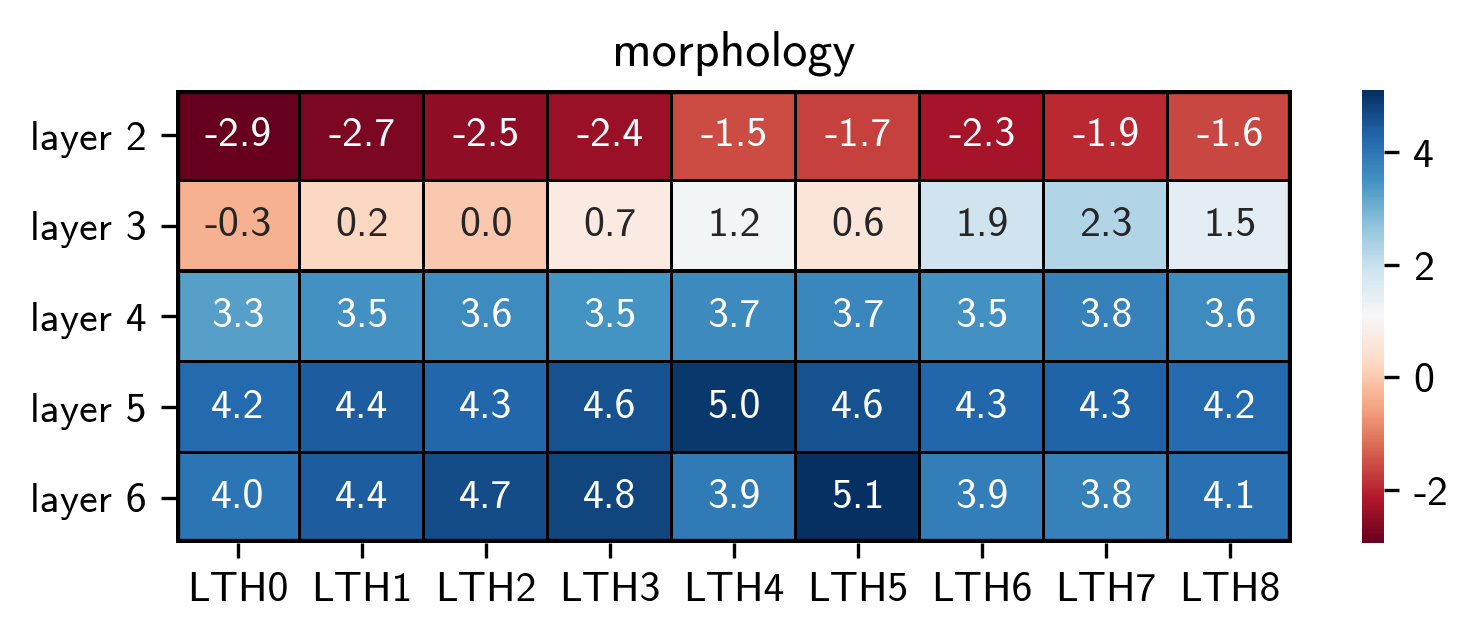

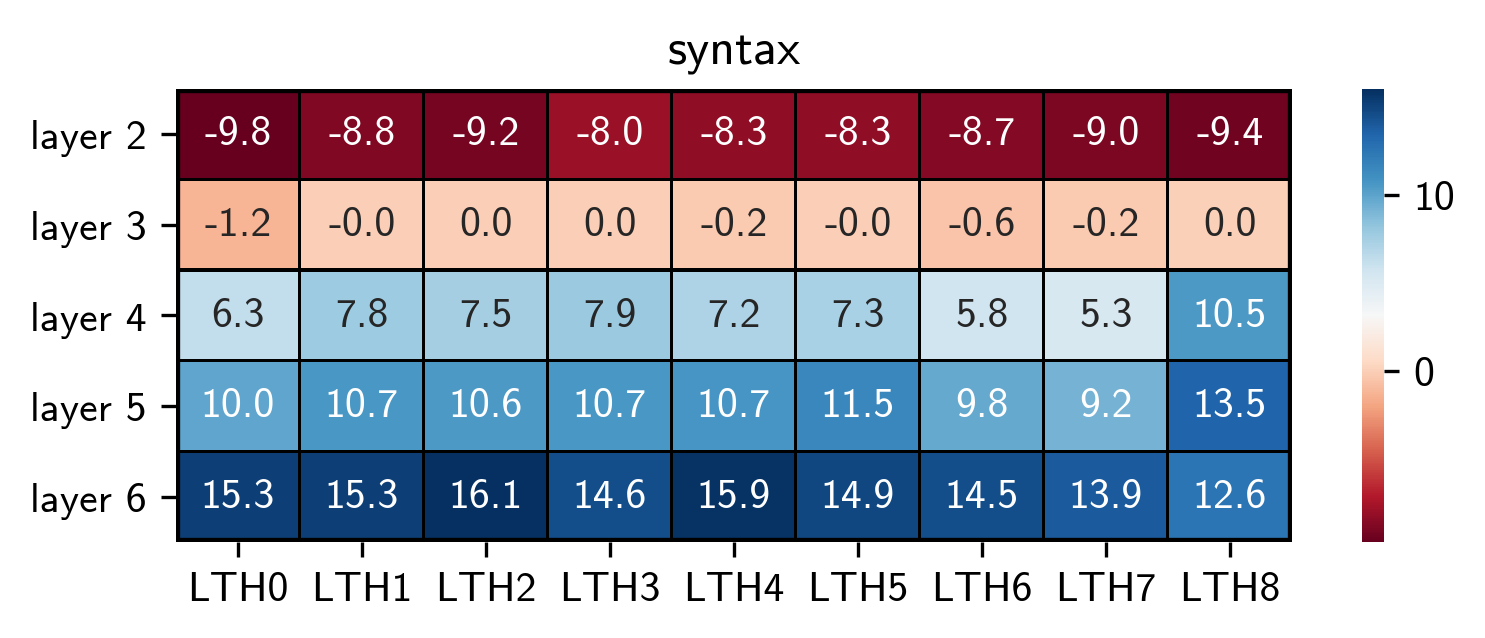

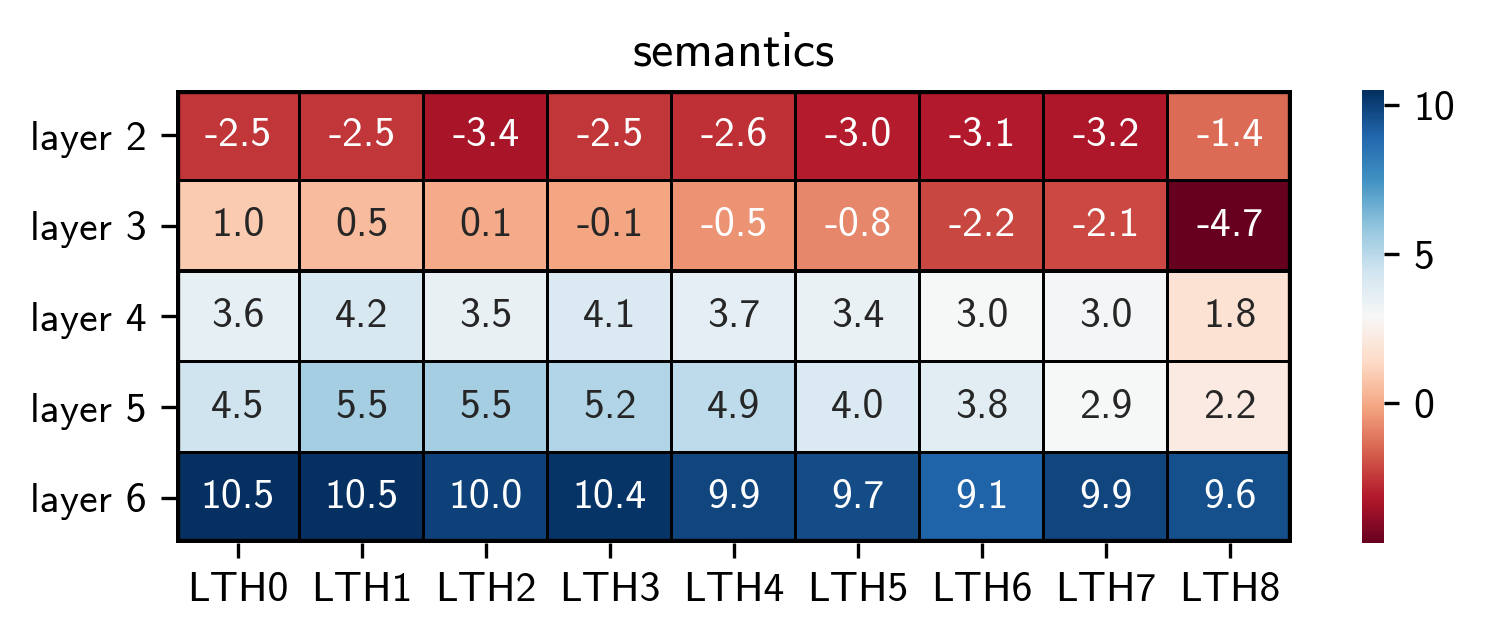

In [176]:
for task_type in averaged_dfs:
    plt.figure(figsize=(6, 2), dpi=300)
    df = averaged_dfs[task_type].iloc[1:, :]
    ax = sns.heatmap(data=df, cmap='RdBu', lw=0.5, linecolor='k', annot=True, fmt='.1f') # vmin=np.nanmin(df.values), vmax=np.nanmax(df.values))
    ax.add_patch(Rectangle((0, 0), len(df.columns), len(df.index), fill=False, edgecolor='black', lw=2))
    ax.set_title(task_type)
    plt.show()

ccg_supertagging


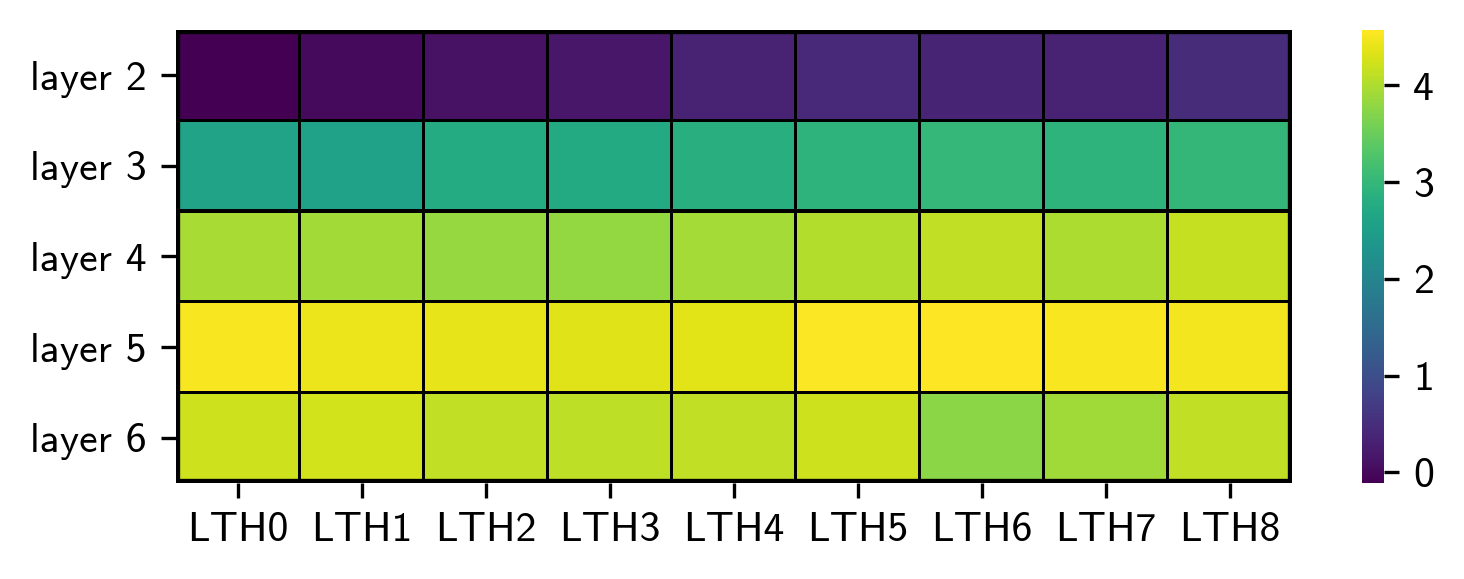

syntactic_constituency_parent


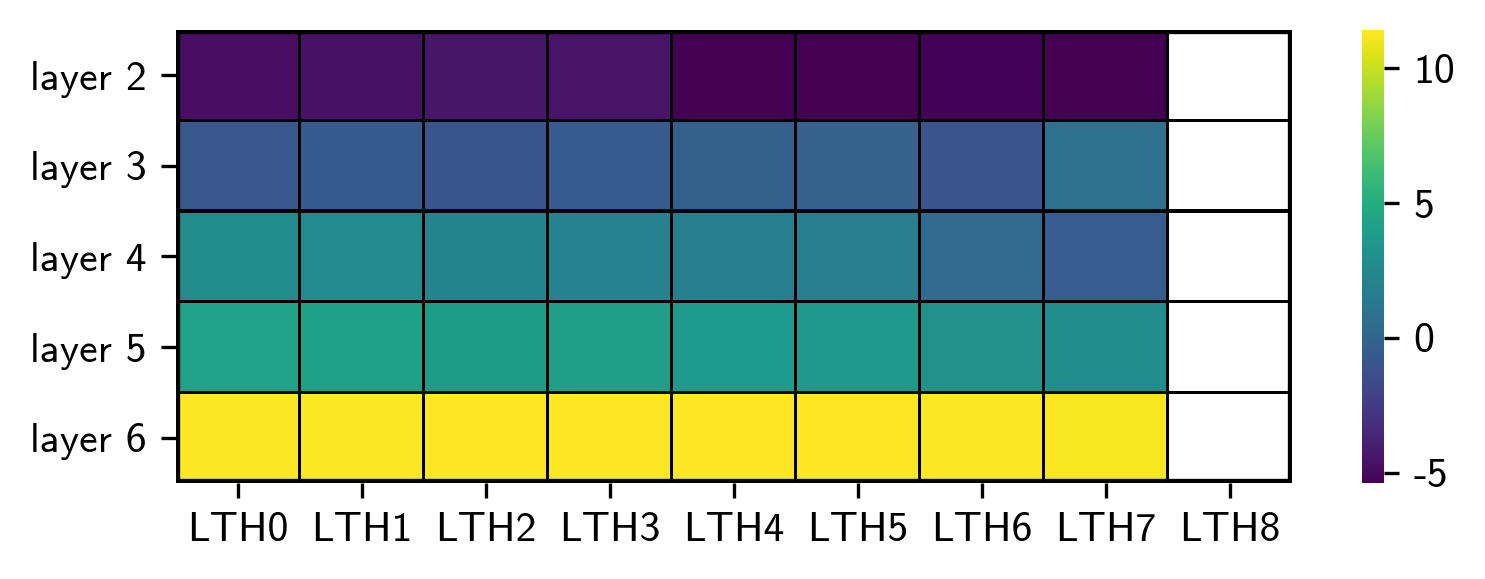

syntactic_constituency_gparent


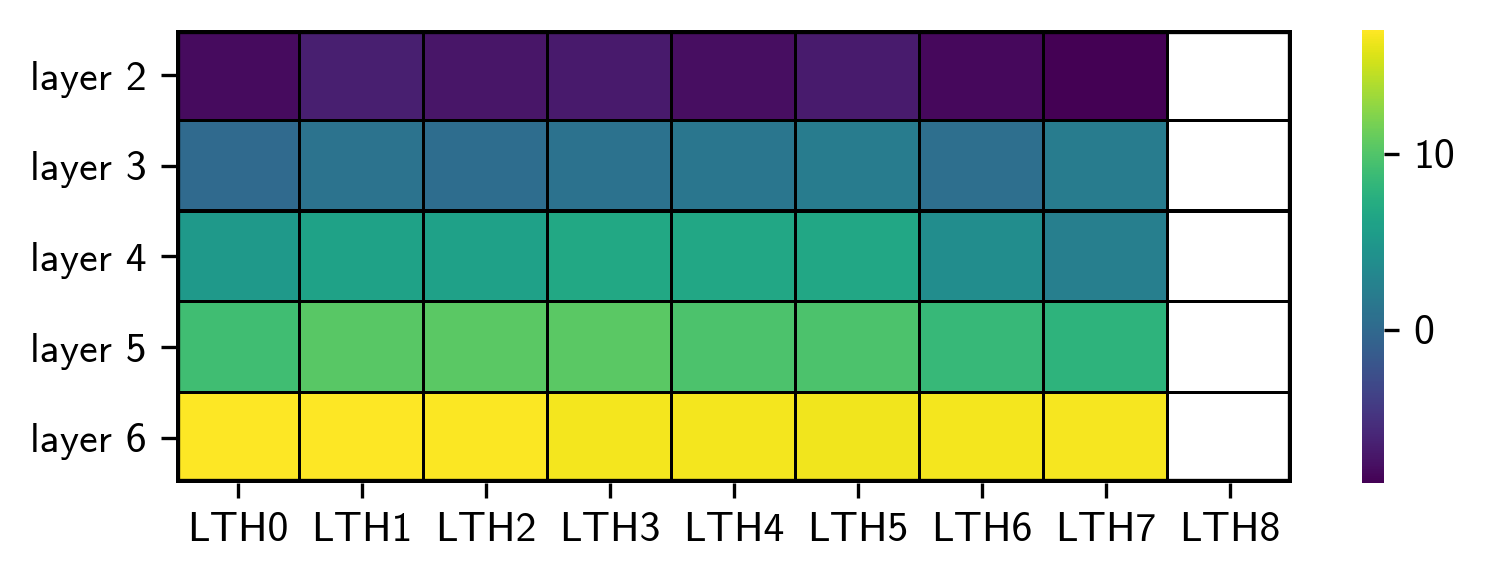

syntactic_constituency_ggparent


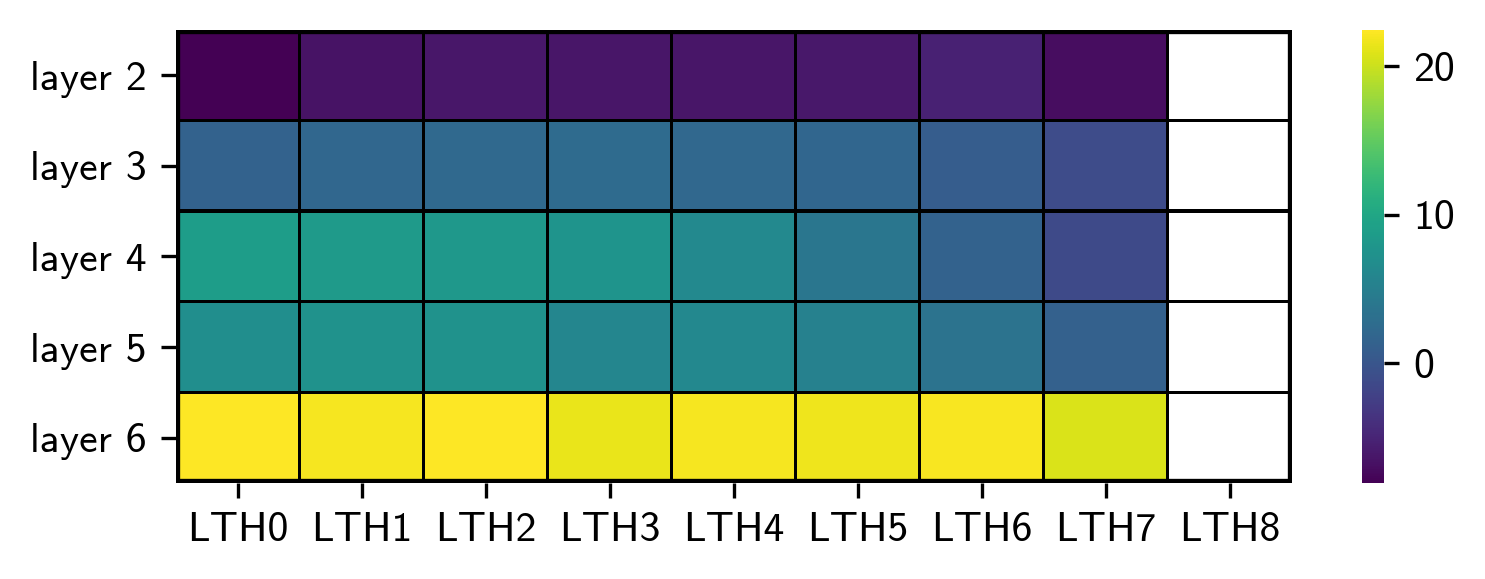

conll2000_chunking


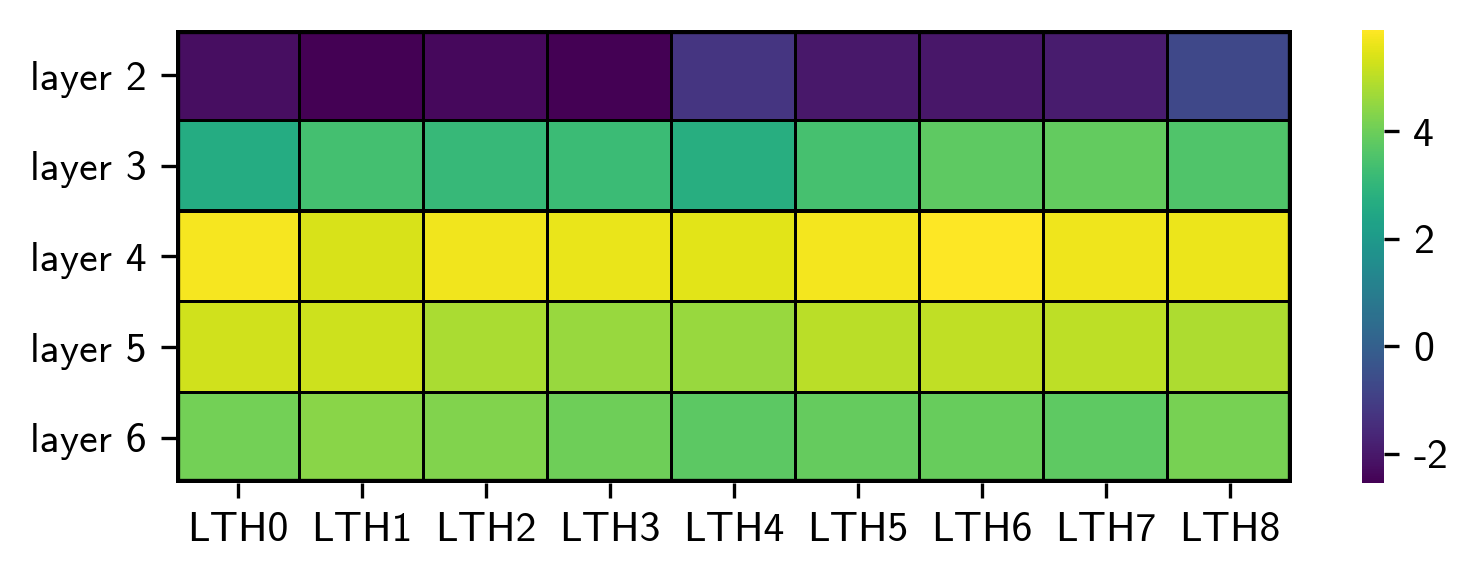

grammatical_error_correction


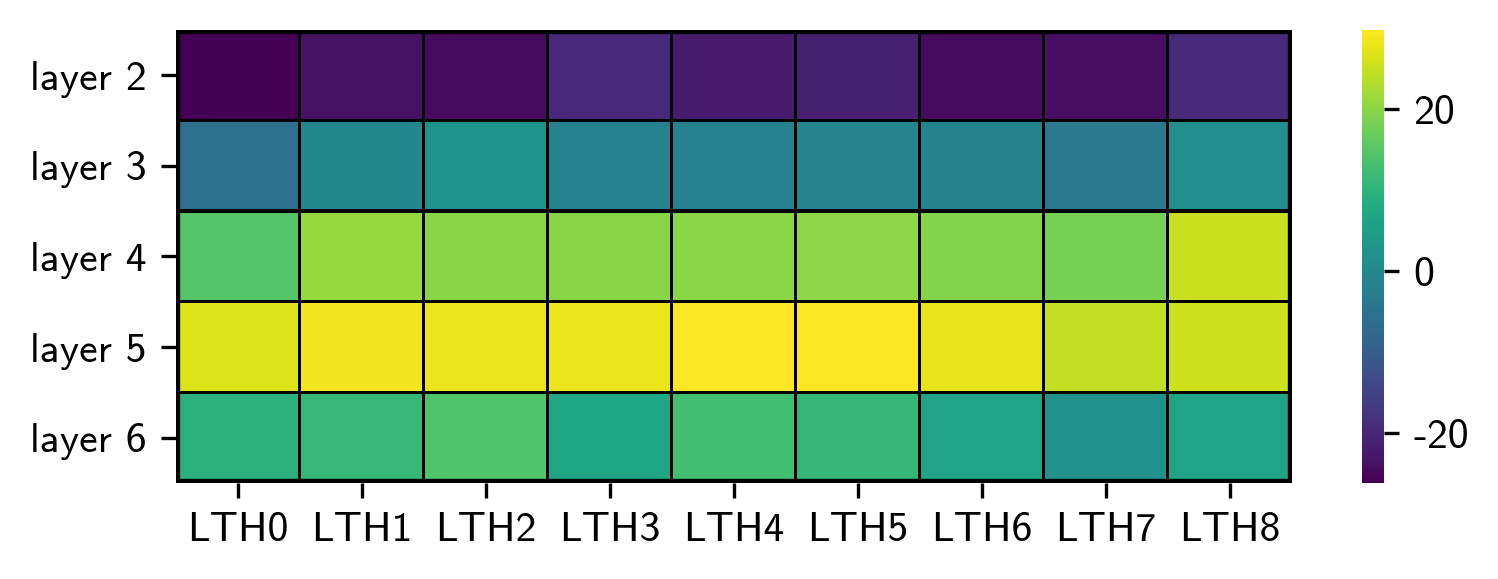

conjunct_identification


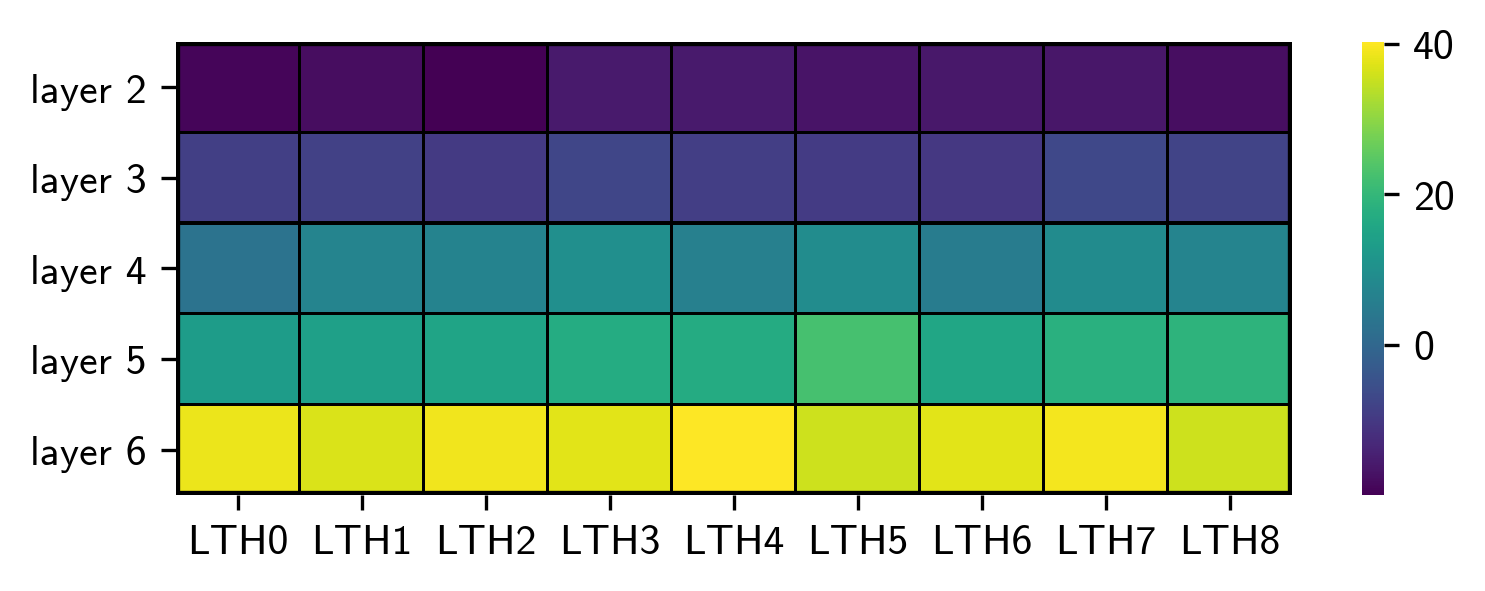

In [177]:
for task in task_types['syntax']:
    print(task)
    plt.figure(figsize=(6, 2), dpi=300)
    df = pd.DataFrame(metric_gain_dict[task], index=[f'layer {i+1}' for i in range(6)])
    ax = sns.heatmap(data=df.iloc[1:,:], cmap='viridis', lw=0.5, linecolor='k') # vmin=np.nanmin(df.values), vmax=np.nanmax(df.values))
    ax.add_patch(Rectangle((0, 0), len(df.columns), len(df.index)-1, fill=False, edgecolor='black', lw=2))
    plt.show()

In [137]:
model_metric_distributions = {model : [] for model in models}
for task in tasks:
    for model in models:
        model_metric_distributions[model].extend(metric_gain_dict[task][model])

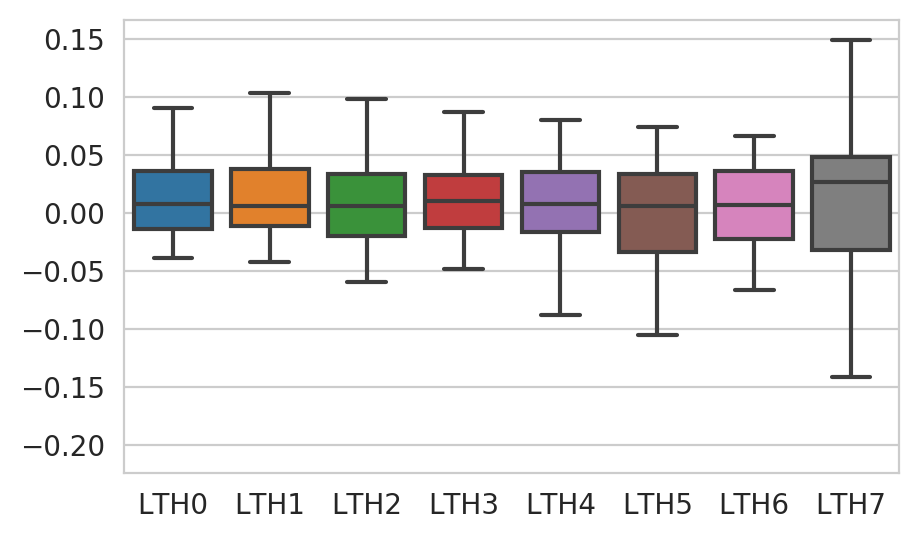

In [153]:
df = pd.DataFrame(model_metric_distributions)

sns.set_style('whitegrid')
plt.figure(figsize=(5,3), dpi=200)
ax = plt.gca()
sns.boxplot(data=df, ax=ax, fliersize=0)
# sns.swarmplot(data=df, color=".25", ax=ax)